In [1]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
from ta.volume import MFIIndicator 
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)
from ta.trend import EMAIndicator

In [2]:
data = pd.read_csv('.\data1mins.csv')
data

Loading ITables v2.5.2 from the internet... (need help?)


In [3]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [4]:
from scipy.signal import butter, lfilter

def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype = 'low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [5]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2073, 3, 16),
 datetime.date(2133, 5, 21),
 datetime.date(2122, 1, 15),
 datetime.date(2131, 11, 15),
 datetime.date(2108, 6, 21),
 datetime.date(2181, 8, 16),
 datetime.date(2036, 6, 19),
 datetime.date(2030, 12, 19),
 datetime.date(2124, 9, 21),
 datetime.date(2250, 7, 18),
 datetime.date(2044, 11, 17),
 datetime.date(2216, 4, 18),
 datetime.date(2178, 1, 15),
 datetime.date(2231, 10, 20),
 datetime.date(2088, 10, 21),
 datetime.date(2174, 4, 21),
 datetime.date(2175, 10, 19),
 datetime.date(2259, 4, 21),
 datetime.date(2017, 8, 17),
 datetime.date(2253, 2, 17),
 datetime.date(2210, 12, 20),
 datetime.date(2085, 8, 16),
 datetime.date(2195, 2, 19),
 datetime.date(2039, 11, 17),
 datetime.date(2152, 12, 21),
 datetime.date(2073, 8, 17),
 datetime.date(2036, 11, 20),
 datetime.date(2154, 6, 20),
 datetime.date(2088, 5, 20),
 datetime.date(2136, 6, 21),
 datetime.date(2229, 9, 17),
 datetime.date(2080, 4, 18),
 datetime.date(2253, 4, 21),
 datetime.date(2193, 6, 20),
 dat

In [6]:
# AverageTrueRange, CCIIndicator, IchimokuIndicator, MACD, RSI, ADXIndicator, RSI, stochastic,
def alpha(data, params):
    data['Close_filtered'] = pd.Series(lowpass_filter(data['Close'], params['t1']))#0.75. dùng lowpass_filter để lọc bớt nhiễu
    #tính chỉ báo 
    data['RSI'] = RSIIndicator(close=data['Close'], window = params['w1']).rsi()
    data['MFI'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close'], volume=data['Volume'], window = params['w1'])
    #
    
    pos = 0
    position = []
    for i in range(len(data)):
        #
        RSI = data['RSI'].values[i]
        #
        if pos == 0:
            #điều kiện enter long
            if RSI < params['t2']:#13. threshold to enter short 30
                pos = -1
            #điều kiện vào short
            if RSI > params['t3']:#81. threshold to enter long 70
                pos = 1
        elif pos == -1:
            #thoát short
            if RSI > params['t5']:#59. threshold to exit short
                pos = 0
        else:
            #thoát long
            if RSI < params['t4']:#37. threshold to exit long
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            #thoát short cuối ngày(CÓ THỂ HOẶC KHÔNG)
            if pos == - 1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    #mục đích cuối cùng vẫn là cột pos(position)
    data['pos'] = position
    return data
#CÁC ĐIỀU KIỆN CÓ TRÊN LÀ NHỮNG ĐIỀU KIỆN ĐƠN SƠ, ĐỂ CÓ 1 ALPHA TỐT, RESEARCHER CẦN NGHIÊN CỨU VÀ ADD THÊM CÁC ĐIỀU KIỆN KHÁC

In [7]:
# # pip install optuna ta pandas numpy
# import optuna
# import numpy as np
# import pandas as pd

# # ==== Metric & backtest (gọn, không lookahead) ====
# def compute_metrics(df, price_col='Close', pos_col='pos',
#                     slip_bps=1.0, fee_bps=1.0):
#     """
#     - slip_bps, fee_bps: chi phí mỗi lần đổi vị thế (basis points, 1 bps = 0.01%)
#     - Trả về Sharpe (annualized ~252 ngày), MDD, #trades
#     """
#     df = df.copy()

#     # Lợi nhuận theo % mỗi bar
#     ret = df[price_col].pct_change().fillna(0.0)
#     pos = df[pos_col].fillna(0.0)

#     # Khớp lệnh bar sau để tránh lookahead trong P&L
#     pos_shift = pos.shift(1).fillna(0.0)
#     strat_ret = ret * pos_shift

#     # Phí/ trượt giá khi thay đổi vị thế (đơn giản: khi |Δpos| > 0)
#     delta_pos = pos.diff().abs().fillna(0.0)
#     trade_cost = (slip_bps + fee_bps) / 10000.0
#     cost = delta_pos * trade_cost
#     # Trừ chi phí vào lợi nhuận
#     strat_ret = strat_ret - cost

#     # Gộp theo ngày để tính Sharpe ngày
#     if 'Date' in df.columns:
#         day = pd.to_datetime(df['Date']).dt.date
#         daily_ret = strat_ret.groupby(day).sum()
#     else:
#         daily_ret = strat_ret

#     mean = daily_ret.mean()
#     std  = daily_ret.std(ddof=1)
#     sharpe = 0.0 if std == 0 else (mean / std) * np.sqrt(252)

#     # MDD
#     eq = (1 + daily_ret).cumprod()
#     dd = (eq.cummax() - eq) / eq.cummax()
#     mdd = dd.max() if len(dd) else 0.0

#     # Số lần đổi vị thế (đếm “giao dịch”)
#     trades = int((delta_pos > 0).sum())

#     return {'sharpe': float(sharpe), 'mdd': float(mdd), 'trades': trades}

# import numpy as np
# import pandas as pd
# import optuna
# from datetime import datetime

# # ----- helper: tạo 3 fold thời gian liên tiếp (70/15/15 mặc định) -----
# def time_folds_index(n, ratios=(0.7, 0.15, 0.15)):
#     a, b, c = ratios
#     i1 = int(n * a)
#     i2 = int(n * (a + b))
#     # 3 fold liên tiếp: [0,i1), [i1,i2), [i2,n)
#     return [(0, i1), (i1, i2), (i2, n)]

# def make_objective(data, expiration_dates=None, base_params=None,
#                    slip_bps=1.0, fee_bps=1.0,
#                    use_time_cv=True):
#     """
#     - data: DataFrame đã resample và có cột Date (datetime)
#     - alpha: dùng chính alpha(data, params) của bạn
#     - base_params: mặc định ban đầu (không bị optimize)
#     - slip_bps, fee_bps: chi phí mỗi lần đổi vị thế
#     - use_time_cv: True -> tính điểm = Sharpe trung bình trên 3 fold thời gian
#     """
#     base_params = dict(base_params or {})
#     data = data.copy().reset_index(drop=True)

#     def objective(trial: optuna.Trial):
#         # ===== Search space =====
#         # RSI thresholds (entry ở cực trị, exit ở vùng giữa)
#         t2 = trial.suggest_float('t2', 10, 45)   # RSI low  (entry long)
#         t3 = trial.suggest_float('t3', 55, 90)   # RSI high (entry short)
#         t4 = trial.suggest_float('t4', 40, 60)   # RSI exit long (về vùng giữa)
#         t5 = trial.suggest_float('t5', 40, 60)   # RSI exit short

#         # MFI thresholds
#         t6 = trial.suggest_float('t6', 10, 45)   # MFI low  (entry long)
#         t7 = trial.suggest_float('t7', 55, 90)   # MFI high (entry short)
#         t8 = trial.suggest_float('t8', 40, 70)   # MFI exit short (về giữa)
#         t9 = trial.suggest_float('t9', 30, 60)   # MFI exit long

#         # windows
#         w1 = trial.suggest_int('w1', 10, 30)     # RSI
#         w2 = trial.suggest_int('w2', 10, 30)     # MFI

#         # ===== Ràng buộc mềm (penalty) =====
#         penalty = 0.0
#         # RSI: entry < exit (long: t2<t4) ; (short: t5<t3)
#         if not (t2 < t4): penalty += (t2 - t4 + 1e-6)
#         if not (t5 < t3): penalty += (t5 - t3 + 1e-6)
#         # MFI: entry < exit (long: t6<t9) ; (short: t8<t7)
#         if not (t6 < t9): penalty += (t6 - t9 + 1e-6)
#         if not (t8 < t7): penalty += (t8 - t7 + 1e-6)

#         params = {
#             't1': base_params.get('t1', 0.75),
#             'w1': w1, 'w2': w2,
#             't2': t2, 't3': t3, 't4': t4, 't5': t5,
#             't6': t6, 't7': t7, 't8': t8, 't9': t9,
#         }

#         # ===== chấm điểm: Sharpe after-fee =====
#         def score_slice(df_slice):
#             df_pos = alpha(df_slice, params)
#             metrics = compute_metrics(df_pos, slip_bps=slip_bps, fee_bps=fee_bps)
#             score = metrics['sharpe']
#             # phạt ràng buộc
#             if penalty > 0:
#                 score -= 5.0 * penalty
#             # phạt quá ít giao dịch
#             if metrics['trades'] < 8:
#                 score -= 0.5
#             # (tùy chọn) risk-aware: score -= 0.5 * metrics['mdd']
#             return float(score)

#         if use_time_cv:
#             n = len(data)
#             folds = time_folds_index(n, ratios=(0.7, 0.15, 0.15))
#             scores = []
#             for (s, e) in folds:
#                 df_slice = data.iloc[s:e].copy()
#                 if len(df_slice) < 200:  # tránh fold quá ngắn
#                     continue
#                 scores.append(score_slice(df_slice))
#             if not scores:
#                 return -1e9
#             score = float(np.mean(scores))
#         else:
#             score = score_slice(data)

#         trial.report(score, step=0)
#         return score

#     return objective

# sampler = optuna.samplers.TPESampler(seed=42, multivariate=True, group=True)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)

# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

# base_params = {'t1': 0.75}  # các tham số cố định khác nếu có
# study.optimize(make_objective(data, base_params=base_params,
#                               slip_bps=1.0, fee_bps=1.0, use_time_cv=True),
#                n_trials=200, show_progress_bar=True)

# print("Best Sharpe (CV):", study.best_value)
# print("Best params:", study.best_params)

# best_params = base_params.copy(); best_params.update(study.best_params)
# df_best = alpha(data, best_params)
# final = compute_metrics(df_best, slip_bps=1.0, fee_bps=1.0)
# print("Final (full sample) metrics:", final)


In [ ]:
# params = {'t1': 0.75, 't2': 36, 't3': 58,  't4': 61, 't5': 35, 'w1': 10, 't6': 25, 't7': 70, 't8': 45, 't9': 55, 'w2': 20}

In [13]:
params = {'t1': 0.75, 't2': 13, 't3': 70, 't4': 45, 't5': 55, 'w1': 20}

In [14]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 17.16
MDD: 78.8 (5.1%)

   Total trading quantity: 240
         Profit per trade: 3.39
             Total Profit: 895.0
         Profit after fee: 813.9
 Trading quantity per day: 0.13
 Profit per day after fee: 0.43
                   Return: 0.07
          Profit per year: 106.82
                  HitRate: 0.53
          HitRate per day: 0.2


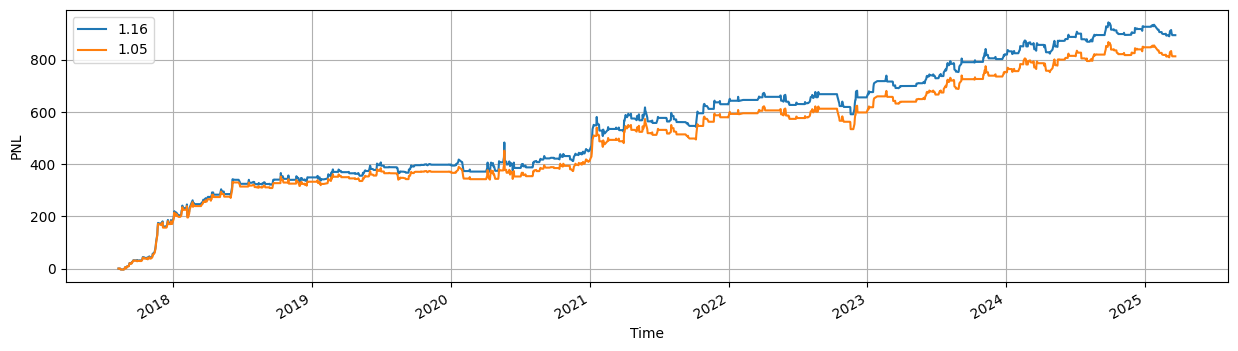

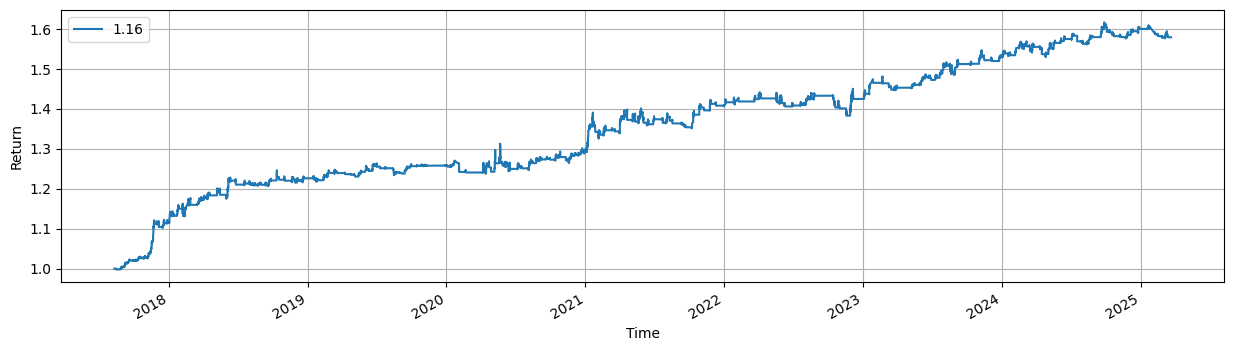

In [15]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [16]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [17]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
